<a href="https://colab.research.google.com/github/RayOfLight07/Deep-Learning/blob/main/DL_LAB_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep learning Lab_________________________________________________________________________Name: Deepasnhu Rathore     
B.Tech. 5th Sem.
#**Experiment:- 12**
# Probabilistic Image Generation with Variational Autoencoders (VAEs)

Date:18\11\2025____________________________________________________________________________________SAP: 500124406

## **AIM**

 To implement a Variational Autoencoder (VAE) using TensorFlow/Keras to generate novel handwritten digits.

# **Objectives**
*   To learn the concept of probabilistic latent spaces (distributions) versus fixed latent points.
*   To implement the Reparameterization Trick for backpropagation.
*   To visualize the 2D latent space to analyze how different classes of digits cluster together.

# **Theory**

A Variational Autoencoder (VAE) is a generative model. Unlike a standard Autoencoder which maps an input to a fixed vector, a VAE maps an input to a probability distribution (mean $\mu$ and variance $\sigma^2$) in the latent space.

**Key Concepts:**
*   **Probabilistic Encoder:** Maps input $x$ to a distribution parameters $z\_mean$ ($\mu$) and $z\_log\_var$ ($\sigma$).
*   **Reparameterization Trick:** To allow backpropagation through random sampling, we express $z$ as:$$z = \mu + \sigma \cdot \epsilon$$
(where $\epsilon$ is random noise from a standard normal distribution).
*   **Decoder:** Samples a point $z$ from the distribution and reconstructs the image.
*   **Loss Function:** It is the sum of two losses:
    *   **Reconstruction Loss:** Forces the output to look like the input (e.g., Binary Crossentropy).
    *   **KL Divergence:** A regularization term that forces the learned distribution to look like a standard Normal distribution (Gaussian).

#**Algorithm**

*   **Input:** Load MNIST data.
*   **Encoder Network:** Define layers to output two vectors: Mean ($\mu$) and Log Variance ($\log \sigma^2$).
*   **Sampling Layer:** Implement the function $z = \mu + \exp(0.5 \cdot \log \sigma^2) \cdot \epsilon$.
*   **Decoder Network:** Takes $z$ as input and outputs the reconstructed image.
*   **Training:** Optimize the combined loss (Reconstruction + KL) using Gradient Descent.
*   **Analysis:** Plot the 2D latent space coloring points by their digit class to see clusters.

# **Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.19.0


# **Load and Preprocess Data**
We add a channel dimension (28, 28, 1) here for compatibility with general convolution layers, though we will use Dense layers for simplicity in this specific example.

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Flatten images: (28, 28) -> (784,)
x_train = x_train.reshape((len(x_train), 784))
x_test = x_test.reshape((len(x_test), 784))

print(f"Training Data Shape: {x_train.shape}")
print(f"Testing Data Shape: {x_test.shape}")

Training Data Shape: (60000, 784)
Testing Data Shape: (10000, 784)


# **Define the Sampling Layer and VAE Architecture**
This defines the custom logic for the VAE.

In [ ]:
# --- 1. Define the Sampling Layer ---
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 2. Define Encoder and Decoder ---
latent_dim = 2

# Encoder
encoder_inputs = layers.Input(shape=(784,))
x = layers.Dense(64, activation="relu")(encoder_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)
decoder_outputs = layers.Dense(784, activation="sigmoid")(x)
decoder = models.Model(latent_inputs, decoder_outputs, name="decoder")

# --- 3. Define the VAE Model Class (Fixed Loss Calculation) ---
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # --- FIXED LOSS CALCULATION ---
            # binary_crossentropy returns the mean loss per pixel (scalar per image)
            # We multiply by 784 to get the sum of errors over the whole image
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            ) * 784

            # KL Divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Instantiate the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

# **Train the Model**

In [ ]:
print("Starting Training...")
history = vae.fit(x_train, epochs=30, batch_size=128)

Starting Training...
Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - kl_loss: 17.4281 - loss: 280.0186 - reconstruction_loss: 262.5905
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 5.6202 - loss: 182.8619 - reconstruction_loss: 177.2417
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 5.0462 - loss: 174.3817 - reconstruction_loss: 169.3354
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 4.8315 - loss: 171.2934 - reconstruction_loss: 166.4618
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - kl_loss: 4.8083 - loss: 169.7421 - reconstruction_loss: 164.9338
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 4.8283 - loss: 168.4259 - reconstruction_loss: 163.5976
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - kl_loss: 4.8806 - loss: 167.0683 - reconstruction_loss: 162.1876
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - kl_loss: 4.9289 - loss: 166.0254 - reconstruction_loss: 161.0965
Epoch 9/30
469/469 ━━━━

# **Analysis - Plotting the Latent Space**
This cell fulfills the "class-wise latent space representations" requirement. It shows how digits cluster in the 2D space.

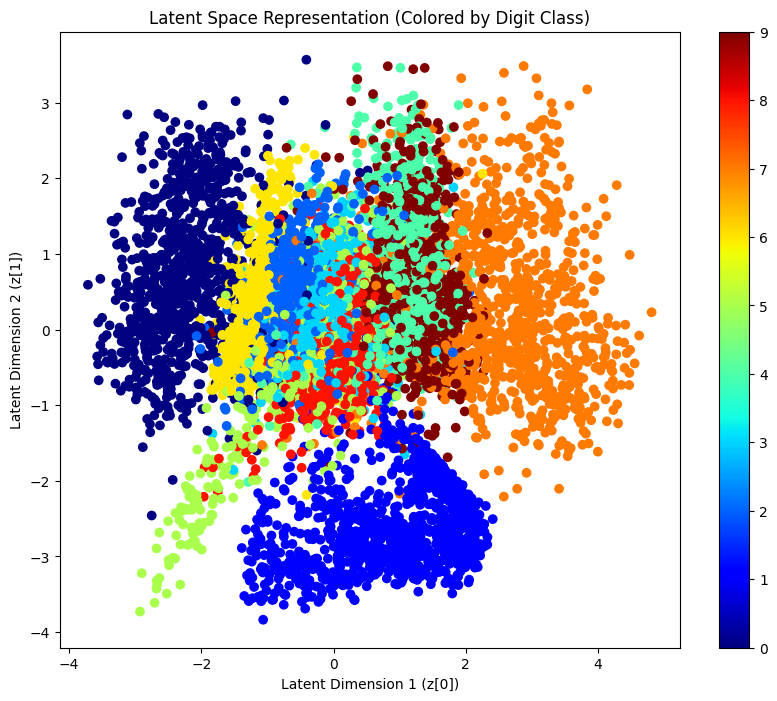

In [ ]:
# 1. Get the encoded representations
# We call the encoder directly to avoid the Keras Graph error
# We convert x_test to a tensor first just to be safe
x_test_tensor = tf.convert_to_tensor(x_test)

# The encoder returns [z_mean, z_log_var, z]. We want [0] (z_mean).
# .numpy() converts the result back to a standard array for plotting
z_mean_encoded = vae.encoder(x_test_tensor)[0].numpy()

# 2. Plot
plt.figure(figsize=(10, 8))
plt.scatter(z_mean_encoded[:, 0], z_mean_encoded[:, 1], c=y_test, cmap='jet')
plt.colorbar()
plt.title("Latent Space Representation (Colored by Digit Class)")
plt.xlabel("Latent Dimension 1 (z[0])")
plt.ylabel("Latent Dimension 2 (z[1])")
plt.show()

# **Generating Novel Images**
This samples random points from the latent space to generate new digits that don't exist in the dataset.

Generating novel digits...


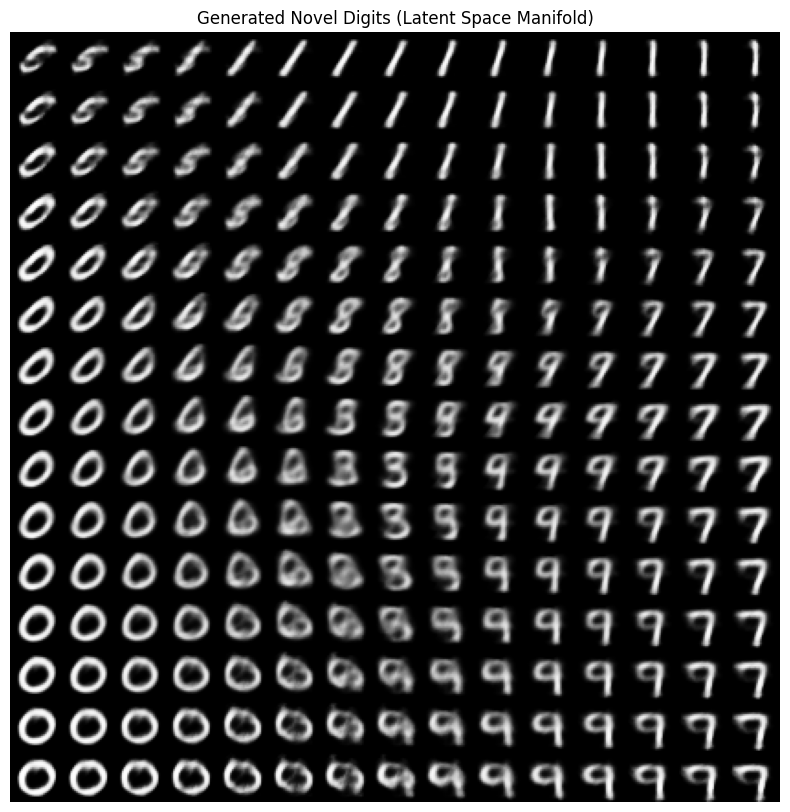

In [ ]:
# Grid settings
n = 15  # 15x15 grid
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Create grid of latent variables
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

print("Generating novel digits...")

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])

        # Convert to tensor for the model
        z_sample_tensor = tf.convert_to_tensor(z_sample, dtype=tf.float32)

        # Call decoder directly
        x_decoded = vae.decoder(z_sample_tensor).numpy()

        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title("Generated Novel Digits (Latent Space Manifold)")
plt.axis('off')
plt.show()

# **Observations**

*   **Latent Space Clustering:** The scatter plot reveals that digits of the same class (e.g., all 0s or all 1s) cluster together in the latent space, forming distinct groups.

*   **Continuous Transition:** The generated grid of images shows a smooth transition between digits (e.g., a '6' slowly morphing into a '0' as we move across the grid). This confirms the manifold is continuous, unlike a standard autoencoder where the space between points might be meaningless noise.

*   **Blurriness:** VAE reconstructions are typically slightly blurrier than standard Autoencoders or GANs due to the probabilistic nature of the loss function.

# **Conclusion**

*    We successfully implemented a Variational Autoencoder. By using the Reparameterization Trick and minimizing the KL Divergence, the model learned a structured, continuous latent representation of the MNIST dataset. This allows for the generation of new, plausible handwritten digits by simply sampling from the latent space.



